Лаборатноая работа номер 4. Бабенко

Дз: Реализовать дерево для задачи регресии

In [362]:
# импорты
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [363]:
# класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [364]:
#  класс листа

class Leaf:

    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.prediction = self.predict()

    def predict(self):
        # находим среднее арифметическое от всех целевых значений для объектов, попавших в этот лист
        return np.mean(self.target)

In [365]:
# Расчет MSE

def MSE(true, pred):
    return np.mean(np.square(true - pred))

In [366]:
# Расчет качества

def quality(left_data, right_data, left_target, right_target, current_mse):

    # коэфициент для нормирования
    p = float(left_target.shape[0]) / (left_target.shape[0] + right_target.shape[0])

    return current_mse - (p*MSE(left_target, np.mean(left_target))  +  (1 - p)*MSE(right_target, np.mean(right_target)))

In [367]:
# Разбиение датасета в узле

def split(data, target, index, t):

    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_target = target[left]
    false_target = target[right]

    return true_data, false_data, true_target, false_target

In [368]:
# Нахождение наилучшего разбиения

def find_best_split(data, target):

    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_mse = MSE(target, np.mean(target))

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_target, false_target = split(data, target, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(left_data = true_data, right_data = false_data, left_target = true_target, right_target = false_data, current_mse = current_mse)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [369]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, target):

    quality, t, index = find_best_split(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, target)

    true_data, false_data, true_target, false_target = split(data, target, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_target)
    false_branch = build_tree(false_data, false_target)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [370]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [371]:
def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [372]:
# сгенерируем данные 
# будем для простоты испольховать только два признака

data, targets = datasets.make_regression(n_samples=1000, n_features=2, noise=1, random_state=32)

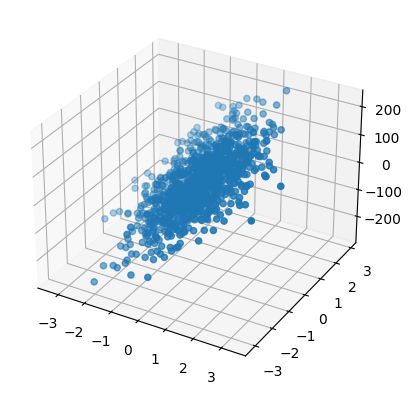

In [373]:
# визуализируем данные

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], targets)

In [374]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_target, test_target = model_selection.train_test_split(data,
                                                                                     targets,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [375]:
# обучим нашу модель

my_tree = build_tree(train_data, train_target)

In [376]:
# Получим ответы для обучающей выборки
train_answers = predict(train_data, my_tree)

In [377]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [378]:
# Введем функцию подсчета точности
def accuracy_metric(tar, predicted):
    rez = 0
    for i in range(len(tar)):
        rez += (tar[i] - predicted[i])**2
    return rez // len(tar)

In [379]:
# Среднеквадратичное отклонение (точность) на обучающей выборке
train_accuracy = accuracy_metric(train_target, train_answers)
train_accuracy

1254.0

In [380]:
# Среднеквадратичное отклонение (точность) на тестовой выборке
test_accuracy = accuracy_metric(test_target, answers)
test_accuracy

1839.0

Вот так у меня получилось реализовать дерево для задачи регрессии. Вместо коэфициента Джини я испольховал MSE, в листьях вместо выделения самого привалируещего класса вычислялось среднее значение по выборке, а в результате с помощью sklern.datasets.make_regrasson создал тестовые данные, разбил их 70/30 как обучающая/тестовая выборка.

И переписал функцию accuracy_metric, которая вернёт среднее кваратичное отклонение по предиктам и реальным ответам. В случае обучающей выборки оно получилось - 1254.0, а тестовой - 1839.0.

Также мы можем изменить критерий останова, в функции find_best_split сделаем максимум количество объектов в листе 1 (min_leaf = 1), тогда точность отклонение на обучающей выборке будет 0.0 (100 процентная точность), но на тестовой сильно возрастёт (переобучение).